In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen

from tqdm import tqdm

import warnings

from bayes_opt import BayesianOptimization

In [2]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 500
CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)


def test(alpha, beta):
    return 10 - alpha - beta


def get_pof_u(alpha, beta):
    matrix_generator = matrix_gen.MatrixGenerator(
        np.random.beta, (alpha, beta), N, N_INTVS
    )
    
    pofs = []
    
    success_count = 0
    while success_count < N_EXPERIMENTS:
        (_, sorted_matrix), __ = matrix_generator.get_increase_matrix_pair(
            round_=False
        )

        _, counts = np.unique(sorted_matrix, return_counts=True)
        if np.any(counts > 1):
            continue


        # Efficient
        eff_assigner = assignment.AssignmentHelperV2(
            sorted_matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(
            eff_assignments, cost_matrix=sorted_matrix
        )

        # Leximin
        lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
            sorted_matrix, CAPACITIES
        )
        lex_assignments = lex_assigner.solve()
        lex_cost = eff_assigner.get_cost(
            lex_assignments, cost_matrix=sorted_matrix
        )


        pofs.append(lex_cost / eff_cost)
        success_count += 1
        
    return np.mean(pofs)


def get_pof_n(alpha, beta):
    matrix_generator = matrix_gen.MatrixGenerator(
        np.random.beta, (alpha, beta), N, N_INTVS
    )
    
    pofs = []
    
    success_count = 0
    while success_count < N_EXPERIMENTS:
        (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
            round_=False
        )

        _, counts = np.unique(sorted_increase_matrix[sorted_increase_matrix > 0], return_counts=True)
        if np.any(counts > 1):
            continue


        # Efficient
        eff_assigner = assignment.AssignmentHelperV2(
            sorted_matrix, CAPACITIES
        )
        eff_assignments = eff_assigner.ip_solve()
        eff_cost = eff_assigner.get_cost(
            eff_assignments, cost_matrix=sorted_matrix
        )

        # Leximin
        lex_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
            sorted_increase_matrix, CAPACITIES
        )
        lex_assignments = lex_assigner.solve()
        lex_cost = eff_assigner.get_cost(
            lex_assignments, cost_matrix=sorted_matrix
        )


        pofs.append(lex_cost / eff_cost)
        success_count += 1
        
    return np.mean(pofs)


def get_lex_cost_ratio(alpha, beta):
    matrix_generator = matrix_gen.MatrixGenerator(
        np.random.beta, (alpha, beta), N, N_INTVS
    )
    
    ratios = []
    
    success_count = 0
    while success_count < N_EXPERIMENTS:
        (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
            round_=False
        )

        # _, counts = np.unique(sorted_matrix, return_counts=True)
        # if np.any(counts > 1):
        #     continue


        # Norm leximin
        lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
            sorted_increase_matrix, CAPACITIES
        )
        lex_n_assignments = lex_n_assigner.solve()
        lex_n_cost = lex_n_assigner.get_cost(
            lex_n_assignments, cost_matrix=sorted_matrix
        )

        # Un-norm Leximin
        lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
            sorted_matrix, CAPACITIES
        )
        lex_u_assignments = lex_u_assigner.solve()
        lex_u_cost = lex_u_assigner.get_cost(
            lex_u_assignments, cost_matrix=sorted_matrix
        )


        ratios.append(lex_u_cost / lex_n_cost)
        success_count += 1
        
    return np.mean(ratios)

# Default

In [20]:
pbounds = {
    'alpha': (0.1, 10), 'beta': (0.1, 10)
}

optimizer = BayesianOptimization(
    f=get_lex_cost_ratio,
    pbounds=pbounds,
    random_state=0
)

In [21]:
optimizer.probe(
    params={'alpha': 0.1, 'beta': 0.1},
    lazy=True
)

optimizer.maximize(
    init_points=5,
    n_iter=100
)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
|  1        |  1.285    |  0.1      |  0.1      |
|  2        |  1.051    |  5.533    |  7.18     |
|  3        |  1.049    |  6.067    |  5.494    |
|  4        |  1.054    |  4.294    |  6.494    |
|  5        |  1.054    |  4.432    |  8.929    |
|  6        |  1.041    |  9.64     |  3.896    |
|  7        |  1.271    |  0.1      |  0.1      |
|  8        |  1.058    |  1.176    |  5.264    |
|  9        |  1.041    |  8.332    |  6.435    |
|  10       |  1.053    |  6.035    |  2.792    |
|  11       |  1.05     |  5.489    |  8.247    |
|  12       |  1.049    |  6.721    |  5.353    |
|  13       |  1.059    |  1.86     |  9.214    |
|  14       |  1.283    |  0.1      |  0.1      |
|  15       |  1.283    |  0.1      |  0.1      |
|  16       |  1.277    |  0.1      |  0.1      |
|  17       |  1.28     |  0.1      |  0.1      |
|  18       |  1.284    |  0.1      |  0.1      |


|  100      |  1.04     |  9.969    |  2.904    |
|  101      |  1.048    |  6.579    |  6.688    |
|  102      |  1.058    |  2.158    |  8.108    |
|  103      |  1.048    |  6.905    |  3.475    |
|  104      |  1.001    |  0.1045   |  3.455    |
|  105      |  1.045    |  7.814    |  8.876    |
|  106      |  1.371    |  0.3372   |  0.1023   |


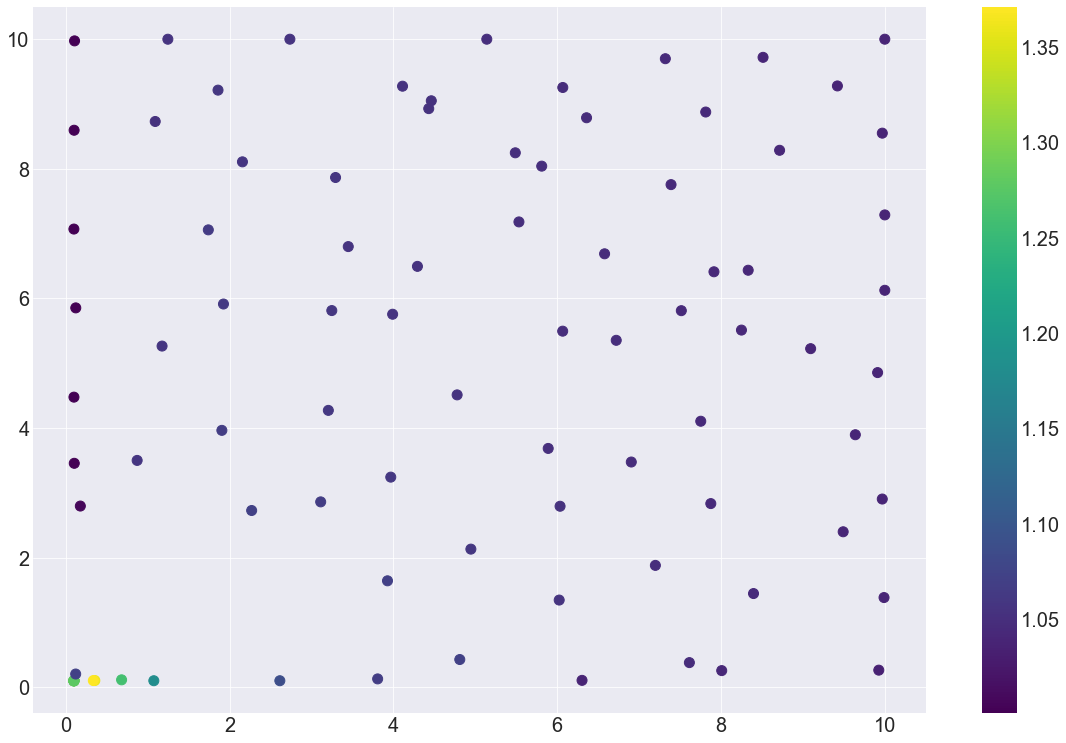

In [31]:
alphas = []
betas = []
target = []

for result in optimizer.res:
    target.append(result['target'])
    alphas.append(result['params']['alpha'])
    betas.append(result['params']['beta'])
    

plt.scatter(alphas, betas, c=target, s=100, cmap='viridis')
plt.colorbar()
plt.show()

# UCB

In [3]:
pbounds = {
    'alpha': (0.1, 1), 'beta': (0.1, 1)
}

optimizer = BayesianOptimization(
    f=get_lex_cost_ratio,
    pbounds=pbounds,
    random_state=0
)

In [4]:
optimizer.maximize(
    init_points=5,
    acq='ucb',
    n_iter=100
)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
|  1        |  1.096    |  0.5939   |  0.7437   |
|  2        |  1.131    |  0.6425   |  0.5904   |
|  3        |  1.083    |  0.4813   |  0.6813   |
|  4        |  1.065    |  0.4938   |  0.9026   |
|  5        |  1.177    |  0.9673   |  0.4451   |
|  6        |  1.264    |  0.1      |  0.1      |
|  7        |  1.234    |  0.7584   |  0.1      |
|  8        |  1.099    |  1.0      |  1.0      |
|  9        |  1.364    |  0.3515   |  0.1      |
|  10       |  1.323    |  0.4562   |  0.1      |
|  11       |  1.193    |  1.0      |  0.1      |
|  12       |  1.286    |  0.2875   |  0.2131   |
|  13       |  1.384    |  0.2765   |  0.1      |
|  14       |  1.001    |  0.1      |  1.0      |
|  15       |  1.407    |  0.2564   |  0.1      |
|  16       |  1.001    |  0.1      |  0.5892   |
|  17       |  1.13     |  1.0      |  0.722    |
|  18       |  1.084    |  0.743    |  1.0      |


|  100      |  1.36     |  0.3368   |  0.1295   |
|  101      |  1.326    |  0.2374   |  0.1655   |
|  102      |  1.354    |  0.3746   |  0.1319   |
|  103      |  1.331    |  0.3586   |  0.1665   |
|  104      |  1.335    |  0.3184   |  0.1639   |
|  105      |  1.332    |  0.2784   |  0.1663   |


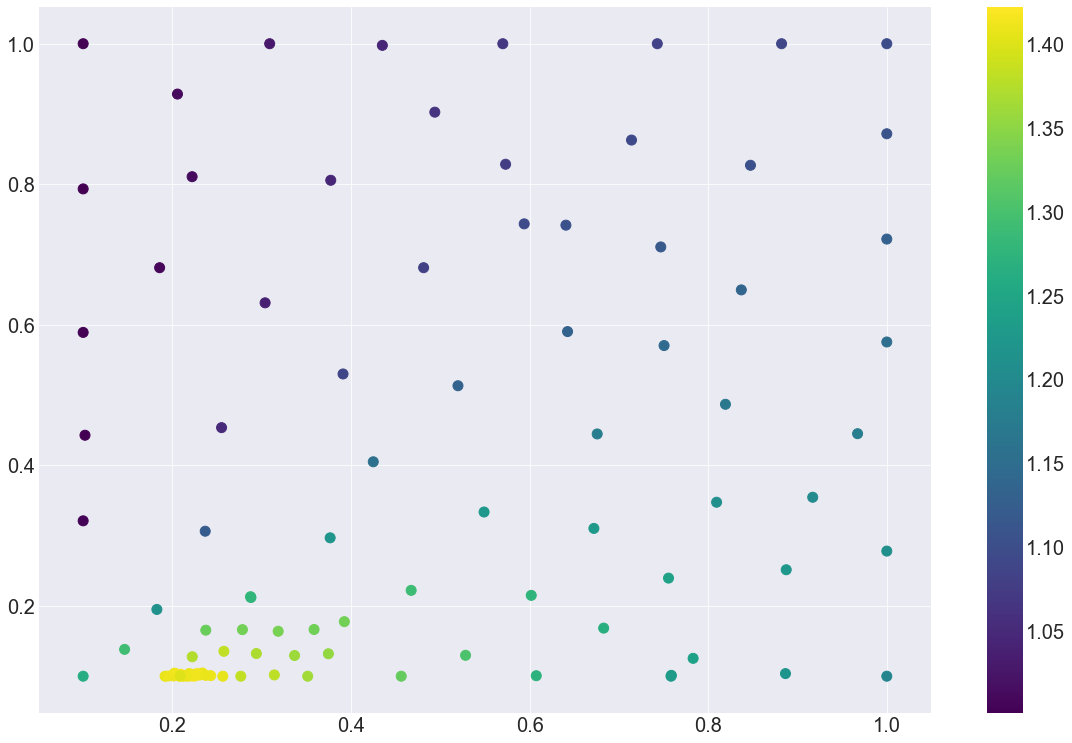

In [5]:
alphas = []
betas = []
target = []

for result in optimizer.res:
    target.append(result['target'])
    alphas.append(result['params']['alpha'])
    betas.append(result['params']['beta'])
    

plt.scatter(alphas, betas, c=target, s=100, cmap='viridis')
plt.colorbar()
plt.show()

# EI

In [3]:
pbounds = {
    'alpha': (0.01, 1), 'beta': (0.01, 1)
}

optimizer = BayesianOptimization(
    f=get_lex_cost_ratio,
    pbounds=pbounds,
    random_state=0
)

In [4]:
optimizer.probe(
    params={'alpha': 0.2, 'beta': 0.1},
    lazy=True
)

optimizer.maximize(
    init_points=5,
    acq='ei',
    n_iter=100
)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
|  1        |  1.41     |  0.2      |  0.1      |
|  2        |  1.093    |  0.5533   |  0.718    |
|  3        |  1.137    |  0.6067   |  0.5494   |
|  4        |  1.074    |  0.4294   |  0.6494   |
|  5        |  1.053    |  0.4432   |  0.8929   |
|  6        |  1.189    |  0.964    |  0.3896   |
|  7        |  1.264    |  0.01     |  0.01     |
|  8        |  1.088    |  0.5035   |  0.01     |
|  9        |  1.099    |  1.0      |  1.0      |
|  10       |  1.0      |  0.0676   |  0.2733   |
|  11       |  1.19     |  0.21     |  0.01     |
|  12       |  1.045    |  1.0      |  0.01     |
|  13       |  1.281    |  0.3611   |  0.2242   |
|  14       |  1.001    |  0.09078  |  0.8162   |
|  15       |  1.4      |  0.2155   |  0.1055   |
|  16       |  1.236    |  0.8323   |  0.1765   |
|  17       |  1.0      |  0.01     |  1.0      |
|  18       |  1.348    |  0.1564   |  0.1199   |


|  100      |  1.231    |  0.7057   |  0.3025   |
|  101      |  1.137    |  0.7028   |  0.6015   |
|  102      |  1.069    |  0.6119   |  0.9999   |
|  103      |  1.458    |  0.1477   |  0.05734  |
|  104      |  1.112    |  0.4818   |  0.5682   |
|  105      |  1.146    |  0.9373   |  0.5948   |
|  106      |  1.226    |  0.9249   |  0.1958   |


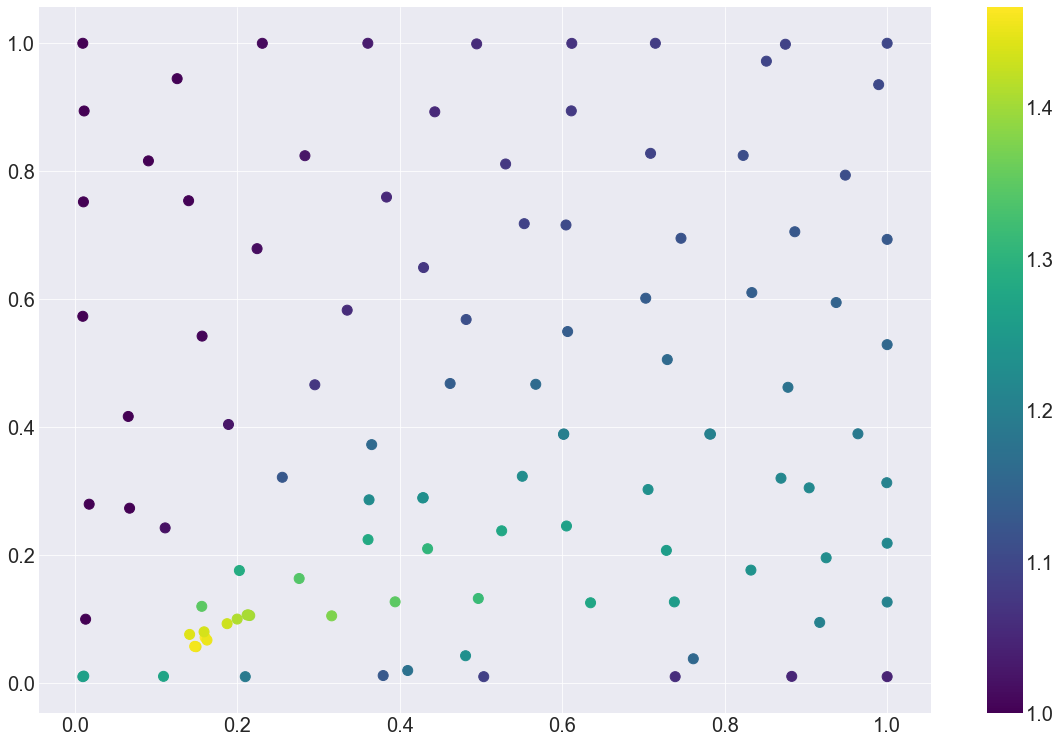

In [5]:
alphas = []
betas = []
target = []

for result in optimizer.res:
    target.append(result['target'])
    alphas.append(result['params']['alpha'])
    betas.append(result['params']['beta'])
    

plt.scatter(alphas, betas, c=target, s=100, cmap='viridis')
plt.colorbar()
plt.show()

# PoI

In [3]:
pbounds = {
    'alpha': (0.01, 1), 'beta': (0.01, 1)
}

optimizer = BayesianOptimization(
    f=get_lex_cost_ratio,
    pbounds=pbounds,
    random_state=0
)

In [4]:
optimizer.probe(
    params={'alpha': 0.2, 'beta': 0.1},
    lazy=True
)

optimizer.maximize(
    init_points=10,
    acq='ei',
    n_iter=1000
)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
|  1        |  1.41     |  0.2      |  0.1      |
|  2        |  1.093    |  0.5533   |  0.718    |
|  3        |  1.137    |  0.6067   |  0.5494   |
|  4        |  1.074    |  0.4294   |  0.6494   |
|  5        |  1.053    |  0.4432   |  0.8929   |
|  6        |  1.189    |  0.964    |  0.3896   |
|  7        |  1.153    |  0.7938   |  0.5336   |
|  8        |  1.073    |  0.5724   |  0.9263   |
|  9        |  1.218    |  0.08033  |  0.09626  |
|  10       |  1.0      |  0.03002  |  0.8343   |
|  11       |  1.099    |  0.7804   |  0.8713   |
|  12       |  1.083    |  0.5202   |  0.01     |
|  13       |  1.318    |  0.2829   |  0.1841   |
|  14       |  1.195    |  0.2224   |  0.01207  |
|  15       |  1.045    |  1.0      |  0.01     |
|  16       |  1.081    |  0.5489   |  0.8247   |
|  17       |  1.424    |  0.2069   |  0.07958  |
|  18       |  1.096    |  1.0      |  1.0      |


|  100      |  1.469    |  0.1211   |  0.05039  |
|  101      |  1.475    |  0.0962   |  0.03351  |
|  102      |  1.472    |  0.09924  |  0.03783  |
|  103      |  1.355    |  0.0868   |  0.01354  |
|  104      |  1.107    |  0.717    |  0.7781   |
|  105      |  1.487    |  0.0789   |  0.03551  |
|  106      |  1.0      |  0.01026  |  0.09554  |
|  107      |  1.113    |  0.4952   |  0.5527   |
|  108      |  1.17     |  0.2296   |  0.2597   |
|  109      |  1.087    |  0.3239   |  0.4514   |
|  110      |  1.119    |  0.9981   |  0.8089   |
|  111      |  1.001    |  0.1042   |  0.5663   |
|  112      |  1.225    |  0.3969   |  0.2928   |
|  113      |  1.462    |  0.09684  |  0.03324  |
|  114      |  1.481    |  0.07903  |  0.04757  |
|  115      |  1.49     |  0.08732  |  0.04318  |
|  116      |  1.204    |  0.998    |  0.115    |
|  117      |  1.497    |  0.08197  |  0.04309  |
|  118      |  1.053    |  0.3959   |  0.7665   |
|  119      |  1.202    |  0.6388   |  0.05106  |


|  200      |  1.358    |  0.3091   |  0.1456   |
|  201      |  1.217    |  0.7018   |  0.06988  |
|  202      |  1.096    |  0.4963   |  0.6377   |
|  203      |  1.11     |  0.6865   |  0.7152   |
|  204      |  1.065    |  0.4996   |  0.948    |
|  205      |  1.201    |  0.7384   |  0.3757   |
|  206      |  1.231    |  0.8841   |  0.1522   |
|  207      |  1.195    |  0.9989   |  0.355    |
|  208      |  1.182    |  0.8877   |  0.0677   |
|  209      |  1.192    |  0.5418   |  0.3961   |
|  210      |  1.078    |  0.644    |  0.9502   |
|  211      |  1.109    |  0.8608   |  0.8423   |
|  212      |  1.313    |  0.4685   |  0.1044   |
|  213      |  1.179    |  0.3295   |  0.3175   |
|  214      |  1.064    |  0.298    |  0.4896   |
|  215      |  1.064    |  0.4472   |  0.8105   |
|  216      |  1.009    |  0.172    |  0.5885   |
|  217      |  1.026    |  0.2893   |  0.9539   |
|  218      |  1.488    |  0.06863  |  0.03252  |
|  219      |  1.144    |  0.7496   |  0.588    |


|  300      |  1.0      |  0.04536  |  0.9668   |
|  301      |  1.242    |  0.8081   |  0.2273   |
|  302      |  1.497    |  0.09472  |  0.04935  |
|  303      |  1.134    |  0.6933   |  0.6078   |
|  304      |  1.243    |  0.5471   |  0.2817   |
|  305      |  1.24     |  0.7333   |  0.1038   |
|  306      |  1.098    |  0.3739   |  0.4925   |
|  307      |  1.127    |  0.8027   |  0.6698   |
|  308      |  1.098    |  0.8858   |  0.9995   |
|  309      |  1.345    |  0.3884   |  0.1464   |
|  310      |  1.004    |  0.1247   |  0.4251   |
|  311      |  1.163    |  0.998    |  0.06572  |
|  312      |  1.276    |  0.4223   |  0.239    |
|  313      |  1.141    |  1.0      |  0.6458   |
|  314      |  1.383    |  0.2403   |  0.05526  |
|  315      |  1.366    |  0.3434   |  0.1232   |
|  316      |  1.0      |  0.05816  |  0.6033   |
|  317      |  1.17     |  0.97     |  0.4719   |
|  318      |  1.354    |  0.1823   |  0.1314   |
|  319      |  1.492    |  0.1038   |  0.05324  |


|  400      |  1.116    |  0.9604   |  0.7754   |
|  401      |  1.131    |  0.7683   |  0.6392   |
|  402      |  1.085    |  0.2677   |  0.3926   |
|  403      |  1.213    |  0.6406   |  0.3621   |
|  404      |  1.107    |  0.582    |  0.6728   |
|  405      |  1.0      |  0.04643  |  0.5559   |
|  406      |  1.01     |  0.1829   |  0.7231   |
|  407      |  1.164    |  0.4711   |  0.4164   |
|  408      |  1.085    |  0.1279   |  0.1962   |
|  409      |  1.479    |  0.105    |  0.05984  |
|  410      |  1.348    |  0.1296   |  0.1085   |
|  411      |  1.088    |  0.6348   |  0.855    |
|  412      |  1.148    |  0.7924   |  0.576    |
|  413      |  1.137    |  0.6569   |  0.5768   |
|  414      |  1.192    |  0.3714   |  0.3264   |
|  415      |  1.071    |  0.3586   |  0.5546   |
|  416      |  1.011    |  0.2159   |  0.9564   |
|  417      |  1.038    |  0.2893   |  0.6378   |
|  418      |  1.108    |  0.9041   |  0.853    |
|  419      |  1.044    |  0.3959   |  0.8999   |


|  500      |  1.182    |  0.5142   |  0.387    |
|  501      |  1.425    |  0.178    |  0.08764  |
|  502      |  1.223    |  0.8099   |  0.3079   |
|  503      |  1.014    |  0.1756   |  0.4361   |
|  504      |  1.299    |  0.5303   |  0.1085   |
|  505      |  1.096    |  0.7116   |  0.8213   |
|  506      |  1.288    |  0.5617   |  0.1844   |
|  507      |  1.104    |  0.4923   |  0.5971   |
|  508      |  1.27     |  0.6385   |  0.102    |
|  509      |  1.288    |  0.4039   |  0.05538  |
|  510      |  1.181    |  0.7784   |  0.4598   |
|  511      |  1.247    |  0.7873   |  0.2556   |
|  512      |  1.089    |  0.7584   |  0.9083   |
|  513      |  1.006    |  0.04162  |  0.1227   |
|  514      |  1.274    |  0.6562   |  0.1275   |
|  515      |  1.002    |  0.1219   |  0.5179   |
|  516      |  1.323    |  0.306    |  0.04719  |
|  517      |  1.079    |  0.4619   |  0.6784   |
|  518      |  1.495    |  0.04635  |  0.02768  |
|  519      |  1.425    |  0.03559  |  0.02811  |


|  600      |  1.035    |  0.3587   |  0.9761   |
|  601      |  1.0      |  0.04978  |  0.3762   |
|  602      |  1.281    |  0.2646   |  0.2133   |
|  603      |  1.135    |  0.9763   |  0.6608   |
|  604      |  1.084    |  0.4057   |  0.5845   |
|  605      |  1.161    |  0.7824   |  0.5031   |
|  606      |  1.263    |  0.4477   |  0.2555   |
|  607      |  1.293    |  0.5351   |  0.2098   |
|  608      |  1.232    |  0.5232   |  0.3136   |
|  609      |  1.243    |  0.7483   |  0.2639   |
|  610      |  1.019    |  0.2537   |  0.9497   |
|  611      |  1.386    |  0.2416   |  0.1249   |
|  612      |  1.333    |  0.4152   |  0.146    |
|  613      |  1.121    |  0.9773   |  0.7338   |
|  614      |  1.093    |  0.8425   |  0.9999   |
|  615      |  1.082    |  0.6435   |  0.9041   |
|  616      |  1.309    |  0.2526   |  0.0314   |
|  617      |  1.108    |  0.7004   |  0.7491   |
|  618      |  1.119    |  0.9832   |  0.03639  |
|  619      |  1.0      |  0.01075  |  0.7216   |


|  700      |  1.244    |  0.5739   |  0.3011   |
|  701      |  1.01     |  0.2042   |  0.9961   |
|  702      |  1.037    |  0.2902   |  0.6026   |
|  703      |  1.101    |  0.8262   |  0.8652   |
|  704      |  1.107    |  0.6503   |  0.7062   |
|  705      |  1.223    |  0.867    |  0.1188   |
|  706      |  1.15     |  0.9811   |  0.5799   |
|  707      |  1.03     |  0.311    |  0.9163   |
|  708      |  1.002    |  0.121    |  0.8449   |
|  709      |  1.306    |  0.5236   |  0.1503   |
|  710      |  1.103    |  0.7474   |  0.8457   |
|  711      |  1.155    |  0.592    |  0.4715   |
|  712      |  1.045    |  0.3631   |  0.7751   |
|  713      |  1.008    |  0.141    |  0.3789   |
|  714      |  1.0      |  0.01002  |  0.4897   |
|  715      |  1.09     |  0.809    |  0.9704   |
|  716      |  1.23     |  0.6588   |  0.3157   |
|  717      |  1.213    |  0.4885   |  0.3402   |
|  718      |  1.0      |  0.01059  |  0.6441   |
|  719      |  1.157    |  0.4409   |  0.4276   |


|  800      |  1.09     |  0.1473   |  0.226    |
|  801      |  1.221    |  0.9112   |  0.1365   |
|  802      |  1.052    |  0.4109   |  0.7936   |
|  803      |  1.172    |  0.682    |  0.4727   |
|  804      |  1.143    |  0.9814   |  0.6264   |
|  805      |  1.126    |  0.7005   |  0.639    |
|  806      |  1.156    |  0.2955   |  0.3186   |
|  807      |  1.062    |  0.8241   |  0.01132  |
|  808      |  1.156    |  0.7684   |  0.5543   |
|  809      |  1.28     |  0.6195   |  0.2022   |
|  810      |  1.339    |  0.2974   |  0.1619   |
|  811      |  1.33     |  0.3332   |  0.1784   |
|  812      |  1.111    |  0.7378   |  0.7522   |
|  813      |  1.143    |  0.5841   |  0.5327   |
|  814      |  1.087    |  0.666    |  0.8774   |
|  815      |  1.046    |  0.4174   |  0.9236   |
|  816      |  1.022    |  0.2552   |  0.7651   |
|  817      |  1.226    |  0.8391   |  0.2917   |
|  818      |  1.205    |  0.9894   |  0.3283   |
|  819      |  1.198    |  0.9151   |  0.09221  |


|  900      |  1.233    |  0.8003   |  0.2845   |
|  901      |  1.007    |  0.1834   |  0.9752   |
|  902      |  1.126    |  0.4487   |  0.4891   |
|  903      |  1.155    |  0.6836   |  0.5284   |
|  904      |  1.03     |  0.2684   |  0.6634   |
|  905      |  1.506    |  0.06046  |  0.02675  |
|  906      |  1.222    |  0.7132   |  0.3117   |
|  907      |  1.282    |  0.1076   |  0.01034  |
|  908      |  1.115    |  0.8598   |  0.7329   |
|  909      |  1.276    |  0.5211   |  0.07497  |
|  910      |  1.029    |  0.0668   |  0.138    |
|  911      |  1.134    |  0.5235   |  0.5283   |
|  912      |  1.18     |  0.2579   |  0.2662   |
|  913      |  1.119    |  0.9879   |  0.7815   |
|  914      |  1.006    |  0.1596   |  0.8361   |
|  915      |  1.001    |  0.1195   |  0.7315   |
|  916      |  1.0      |  0.07637  |  0.9886   |
|  917      |  1.071    |  0.5669   |  0.8993   |
|  918      |  1.111    |  0.7457   |  0.788    |
|  919      |  1.501    |  0.06292  |  0.02765  |


|  1000     |  1.206    |  0.6174   |  0.3642   |
|  1001     |  1.001    |  0.09741  |  0.9249   |
|  1002     |  1.056    |  0.3953   |  0.7356   |
|  1003     |  1.094    |  0.7768   |  0.9356   |
|  1004     |  1.312    |  0.2287   |  0.02952  |
|  1005     |  1.04     |  0.3375   |  0.7502   |
|  1006     |  1.003    |  0.119    |  0.5891   |
|  1007     |  1.33     |  0.4168   |  0.1309   |
|  1008     |  1.0      |  0.06231  |  0.9652   |
|  1009     |  1.353    |  0.3614   |  0.0797   |
|  1010     |  1.032    |  0.3255   |  0.9336   |
|  1011     |  1.142    |  0.7026   |  0.02925  |


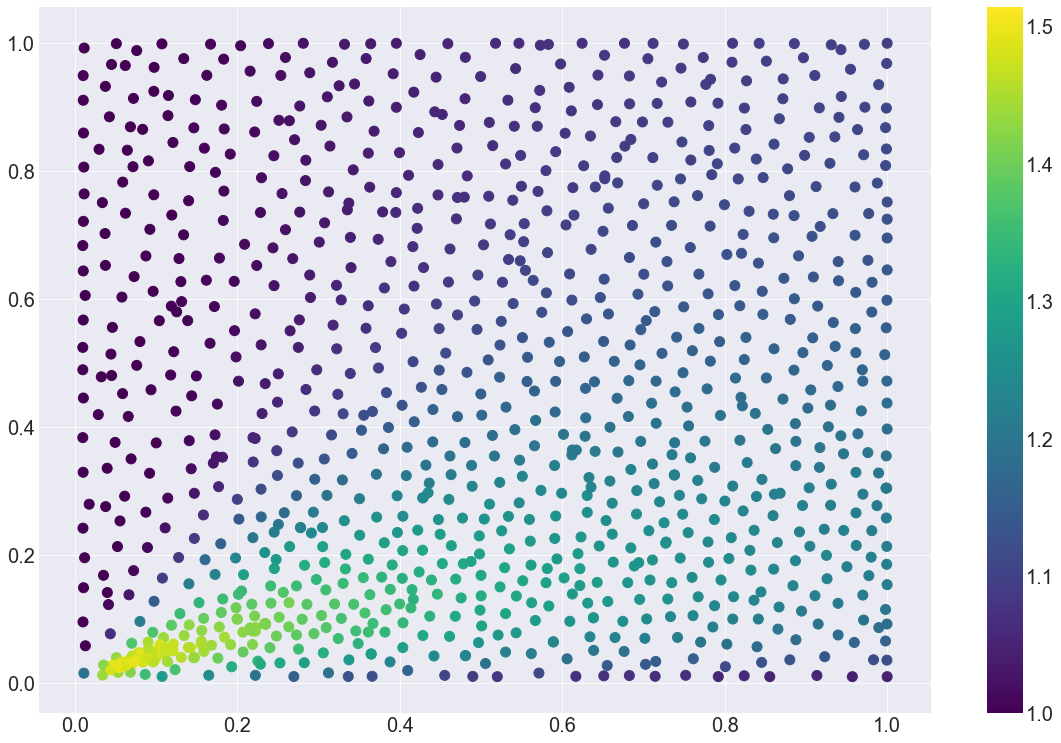

In [5]:
alphas = []
betas = []
target = []

for result in optimizer.res:
    target.append(result['target'])
    alphas.append(result['params']['alpha'])
    betas.append(result['params']['beta'])
    

plt.scatter(alphas, betas, c=target, s=100, cmap='viridis')
plt.colorbar()
plt.show()